# 04_02_check_stars_using_DAOFinder


### import modules

In [1]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy.table import Table

from photutils import DAOStarFinder
from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils import detect_threshold

import warnings

from ccdproc import CCDData

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import _Python_utilities
import _astro_utilities

plt.rcParams.update({'figure.max_open_warning': 0})

/tmp/ipykernel_355261/3346547079.py:15: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder
/tmp/ipykernel_355261/3346547079.py:18: DeprecationWarning: `photutils.detect_threshold` is a deprecated alias for `photutils.segmentation.detect_threshold` and will be removed in the future. Instead, please use `from photutils.segmentation import detect_threshold` to silence this warning.
  from photutils import detect_threshold


# 환경 설정

In [2]:
#%%
verbose = True # False
tryagain = False
#######################################################
BASEDIR = Path("/mnt/Rdata/ASTRO_data")  

PROJECDIR = BASEDIR / "C1-Variable"
TODODIR = PROJECDIR / "-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin"

PROJECDIR = BASEDIR / "A3_CCD_obs_raw"
TODODIR = PROJECDIR / "ASI2600MC_1bin" / "LIGHT_OON300"
# TODODIR = PROJECDIR / "STF-8300M_1bin" / "LIGHT_GSON300"
TODODIR = PROJECDIR / "ASI6200MMPro_3bin" / "LIGHT_RiLA600"

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(TODODIR))
if verbose == True :
    print ("DOINGDIRs: ", format(DOINGDIRs))
    print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

try : 
    BDFDIR = [x for x in DOINGDIRs if "CAL-BDF" in str(x)]
    if verbose == True :
        print ("BDFDIR: ", format(BDFDIR))
    BDFDIR = Path(BDFDIR[0])    
except : 
    BDFDIR = TODODIR
    pass

DOINGDIRs = sorted([x for x in DOINGDIRs if "_LIGHT_" in str(x)])
if verbose == True :
    print ("DOINGDIRs: ", DOINGDIRs)
    print ("len(DOINGDIRs): ", len(DOINGDIRs))
#######################################################

DOINGDIRs:  ['/mnt/Rdata/ASTRO_data/A3_CCD_obs_raw/ASI6200MMPro_3bin/LIGHT_RiLA600/BF-Eri_LIGHT_-_2024-12-08_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/A3_CCD_obs_raw/ASI6200MMPro_3bin/LIGHT_RiLA600/FO-Aqr_LIGHT_-_2024-12-08_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/A3_CCD_obs_raw/ASI6200MMPro_3bin/LIGHT_RiLA600/GPX-1b_LIGHT_-_2025-01-01_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/A3_CCD_obs_raw/ASI6200MMPro_3bin/LIGHT_RiLA600/GPX-1b_LIGHT_-_2025-01-15_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/A3_CCD_obs_raw/ASI6200MMPro_3bin/LIGHT_RiLA600/HAT-P-16b_LIGHT_-_2024-10-01_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/A3_CCD_obs_raw/ASI6200MMPro_3bin/LIGHT_RiLA600/HAT-P-25b_LIGHT_-_2024-12-22_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/A3_CCD_obs_raw/ASI6200MMPro_3bin/LIGHT_RiLA600/HAT-P-61b_LIGHT_-_2025-01-02_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/A3_CCD_obs_raw/ASI6200MMPro_3bin/LIGHT_RiLA600/HAT-P

In [3]:
#%%
#####################################################################
# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
GSHS = EarthLocation(lon=127.005 * u.deg,
                                 lat=37.308889 * u.deg,
                                 height=101 * u.m)
MPC_obscode = "P64"
#######################################################
# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

# Initial guess of FWHM in pixel
FWHM_INIT = 4
FWHM = FWHM_INIT

# Photometry parameters
R_AP = 1.5 * FWHM_INIT # Aperture radius
R_IN = 4 * FWHM_INIT   # Inner radius of annulus
R_OUT = 6 * FWHM_INIT  # Outer radius of annulus
#######################################################

In [5]:
#%%
for DOINGDIR in DOINGDIRs[:1] :
    DOINGDIR = Path(DOINGDIR)
    if verbose == True :
        print("DOINGDIR", DOINGDIR)
    DAOFINDERDIR = DOINGDIR / _astro_utilities.DAOfinder_result_dir
    if not DAOFINDERDIR.exists():
        os.makedirs("{}".format(str(DAOFINDERDIR)))
        if verbose == True :
            print("{} is created...".format(str(DAOFINDERDIR)))
    
    summary = yfu.make_summary(DOINGDIR/"*.fit*",
                                    verify_fix=True,
                                    ignore_missing_simple=True,
                                    )
    if summary is not None :
        if verbose == True :
            print("len(summary):", len(summary))
            print("summary:", summary)
            #print(summary["file"][0])  
        df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
        df_light = df_light.reset_index(drop=True)
        if verbose == True :
            print("df_light:\n{}".format(df_light))
    if verbose == True :
        print("df_light :", df_light)

DELMAG   =   0.0000            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]


DOINGDIR /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2017-01-03_-_RiLA600_STX-16803_-_2bin
All 98 keywords (guessed from /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2017-01-03_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_V_2017-01-03-12-16-01_100sec_RiLA600_STX-16803_-20c_2bin.fit) will be loaded.


DELMAG   =   0.7166            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.7895            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.7972            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.8269            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.8435            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.8339            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.8641            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.8713            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.8837            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.8945            /Veriable - Comparison,   Delmag 

len(summary): 80
summary:                                                  file  filesize  SIMPLE  \
0   /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
1   /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
2   /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
3   /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
4   /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
..                                                ...       ...     ...   
75  /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
76  /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
77  /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
78  /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   
79  /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...   8449920    True   

    BITPIX  NAXIS  NAXIS1  NAXIS2  BSCALE    BZERO OBSERVAT  ...  \
0    

DELMAG   =   0.6204            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]
DELMAG   =   0.4801            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]


In [6]:
summary.columns

Index(['file', 'filesize', 'SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2',
       'BSCALE', 'BZERO', 'OBSERVAT', 'DETECTOR', 'OBSERVER', 'IMAGETYP',
       'FILTER', 'OBJECT', 'DATE-OBS', 'TIME-OBS', 'SIDEREAL', 'EXPTIME',
       'CCD-TEMP', 'SET-TEMP', 'GAIN', 'RDNOISE', 'RA', 'DEC', 'EPOCH',
       'SUBSET', 'AZIMUTH', 'ALTITUDE', 'AIRMASS', 'FOCUSVAL', 'DELMAG',
       'FWHMH', 'FWHMV', 'FWHMHS', 'FWHMVS', 'NSTAR', 'NOTES', 'OPTIC',
       'CCDNAME', 'EXPOSURE', 'EGAIN', 'XBINNING', 'YBINNING', 'FLIPSTAT',
       'TELESCOP', 'FOCALLEN', 'FOCRATIO', 'TELESCOPE', 'APATURE', 'XPIXSZ',
       'YPIXSZ', 'PIXSCALE', 'WCSAXES', 'CTYPE1', 'CTYPE2', 'EQUINOX',
       'LONPOLE', 'LATPOLE', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CUNIT1',
       'CUNIT2', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'IMAGEW', 'IMAGEH',
       'A_ORDER', 'A_0_0', 'A_0_1', 'A_0_2', 'A_1_0', 'A_1_1', 'A_2_0',
       'B_ORDER', 'B_0_0', 'B_0_1', 'B_0_2', 'B_1_0', 'B_1_1', 'B_2_0',
       'AP_ORDER', 'AP_0_0', 'AP_0_1', '

In [7]:
summary[['file', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2']]

,file,CD1_1,CD1_2,CD2_1,CD2_2
0,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-1.150322e-07,3.120737e-07,-0.000345
1,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-1.487065e-07,1.971991e-07,-0.000345
2,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-1.978184e-07,2.411222e-07,-0.000345
3,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-2.341737e-07,2.475745e-07,-0.000345
4,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-1.985167e-07,2.547725e-07,-0.000345
...,...,...,...,...,...
75,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-1.117524e-06,1.204778e-06,-0.000345
76,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-1.140225e-06,1.211517e-06,-0.000345
77,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-1.158081e-06,1.217407e-06,-0.000345
78,/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-0...,-0.000345,-1.129902e-06,1.171080e-06,-0.000345


fpath : /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2017-01-03_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_V_2017-01-03-12-16-01_100sec_RiLA600_STX-16803_-20c_2bin.fit


DELMAG   =   0.0000            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]


DAOfound :  id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 466.17794429356405 ... 1.0717451365381325  -0.0752288035160543
  2 2042.4688574768934 ... 1.7894396112662494   -0.631792616781014
  3 148.04543023240723 ...  1.397608207634885 -0.36346360608213735
  4 397.06106176296544 ... 1.8182210305932303  -0.6491166918960011
  5  271.3738976910508 ...  3.444408394574566  -1.3427865975137059
  6 1718.0593421984886 ...  2.911898329667687   -1.160440518261898
  7 133.34739978910693 ... 1.1371442648908143  -0.1395389134157978
  8 1536.2276562137295 ...  7.399015014533006  -2.1729347715486385
  9 3.6303781646835502 ...  4.042923259672069  -1.5167387447407754
 10 1984.3367534978609 ... 1.5798195582928896  -0.4965187153088133
...                ... ...                ...                  ...
227 1421.1526063962713 ... 1.2526113271922938 -0.24454083662108245
228  86.94467076092117 ... 1.2747607875666602 -0.26

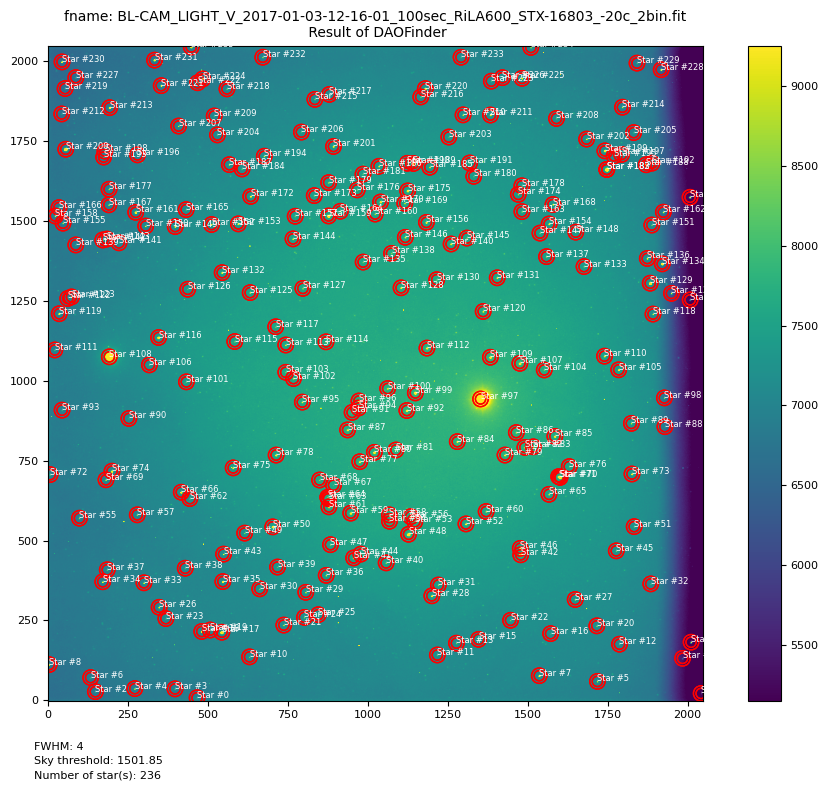

In [8]:
for _, row  in df_light.iterrows():
    fpath = Path(row["file"])
    # fpath = Path(df_light["file"][1])
    if verbose == True :
        print("fpath :" ,fpath)
    hdul = fits.open(fpath)

    ## thres
    # thresh = detect_threshold(data=hdul[0].data, nsigma=3)
    # thresh = thresh[0][0]
    # print('detect_threshold', thresh)

    avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
    thresh = 5. * std
    # print('detect_threshold', thresh)

    DAOfind = DAOStarFinder(
                            fwhm = FWHM, 
                            threshold = thresh, 
                            # sharplo = 0.2, sharphi = 1.0,  # default values: sharplo=0.2, sharphi=1.0,
                            # roundlo = -1.0, roundhi = 1.0,  # default values -1 and +1
                            # sigma_radius = 1.5,           # default values 1.5
                            # ratio = 1.0,                  # 1.0: circular gaussian
                            exclude_border = True         # To exclude sources near edges
                            )
    # The DAOStarFinder object ("DAOfind") gets at least one input: the image.
    # Then it returns the astropy table which contains the aperture photometry results:
    DAOfound = DAOfind(hdul[0].data)
    if verbose == True :
        print("DAOfound :", DAOfound)
        print("len(DAOfound) :",len(DAOfound))
        print(DAOfound.colnames)

    df_DAO = DAOfound.to_pandas()
    if verbose == True :
        print(type(df_DAO))
    df_DAO.to_csv(f"{DAOFINDERDIR}/{fpath.stem}_DAOfinder_fwhm_{FWHM}.csv")
    if verbose == True :
        print("df_DAO.describe :", df_DAO.describe)

    pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
    apert = CAp(pos, r=R_AP)
    annul = CAn(positions=pos, r_in= R_IN, r_out=R_OUT)

    fig, axs = plt.subplots(1, 1, figsize=(12, 8),
                        # subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

    im = _astro_utilities.zimshow(axs, hdul[0].data, )

    axs.tick_params(labelsize=8)

    annul.plot(axs, color="r")
    for i in range(len(pos)):
        axs.text(pos[i][0], pos[i][1], f"Star #{str(i)}", fontsize=6, color='w')

    annul.plot(axs, color="r")

    cbar = plt.colorbar(im, ax = axs, fraction=0.035, pad=0.04, )
    cbar.ax.tick_params(labelsize=8)

    axs.set_title(f"fname: {fpath.name}\n Result of DAOFinder", fontsize=10,)

    axs.annotate(f'FWHM: {FWHM}', fontsize=8,
        xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
        xycoords='axes fraction', textcoords='offset points')

    axs.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
        xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
        xycoords='axes fraction', textcoords='offset points')

    axs.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
        xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
        xycoords='axes fraction', textcoords='offset points')

    plt.tight_layout()
    plt.savefig(f"{DAOFINDERDIR}/{fpath.stem}_DAOfinder_fwhm_{FWHM}.png")

    plt.show()
    break
